In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist
import seaborn as sns

I compare three different aspects of the VAE:

* Different architectures
* Different latent dimension sizes
* Different loss function set ups

The dataset used is MNIST with no transformations:

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32").reshape(x_train.shape[0], 28, 28, 1) / 255.
x_test = x_test.astype("float32").reshape(x_test.shape[0], 28, 28, 1) / 255.

Training the basic dense model:

In [3]:
def train_dense_model(num_dims, recon_loss=True, kl_loss=True, beta=1):

    class latent_sampling(layers.Layer):
        def call(self, mean, log_var):
            return tf.random.normal(tf.shape(mean)) * tf.exp(log_var * 0.5) + mean
    def kl_loss_func(mean, log_var):
        """The reduce_sum sums across all of the latent space features/dimensions,
        as in the original loss function equation.
        The reduce_mean then takes the average across all of the observations.
        Can take a hyperparameter beta, to make the VAE disentangled."""
        return beta * tf.reduce_mean(-0.5 * tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=1))
    def recon_loss_func(y_true, y_pred):
        """From the loss function equation, the negative expectation of log(p(x|z)),
        taking into account the probability distribution of q(x|z),
        is just the same as the cross entropy between those two distributions.
        As in the loss function equation, we also take the sum.
        Binary cross entropy by default takes the average across all of the observations."""
        return tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred), axis=(1, 2))

    encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
    encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
    encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
    encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)
    mean = layers.Dense(units = num_dims, name = 'latent_mean')(encoder_dense_2)
    log_var = layers.Dense(units = num_dims, name = 'latent_log_var')(encoder_dense_2)
    encoder_output = latent_sampling()(mean, log_var)
    encoder = models.Model(inputs=encoder_input, outputs=encoder_output, name = "encoder")

    decoder_input = layers.Input(shape=(num_dims,), dtype='float32')
    decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
    decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
    decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
    decoder_output = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)
    decoder = models.Model(inputs=decoder_input, outputs=decoder_output, name = "decoder")

    encoded_z = encoder(encoder_input)
    reconstructed_x = decoder(encoded_z)
    vae = tf.keras.Model(inputs=[encoder_input], outputs=[reconstructed_x])
    vae.add_metric(kl_loss_func(mean, log_var), name = "kl_loss")

    if kl_loss:
        vae.add_loss(kl_loss_func(mean, log_var))
    if recon_loss:
        vae.compile(loss=recon_loss_func, optimizer="nadam", metrics = [recon_loss_func, 'accuracy'])
    else:
        vae.compile(optimizer="nadam", metrics = [recon_loss_func, 'accuracy'])

    history = vae.fit(x_train, x_train, epochs=30, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

    return history, vae, encoder, decoder

Different functions for plotting:

In [66]:
def plot_test_preds(vae):
    predict = vae.predict(x_test)
    f, ax = plt.subplots(2, 7, figsize = (15,4))
    for i in range(7):
        ax[0,i].imshow(x_test[i+100], cmap="gray")
        ax[1,i].imshow(predict[i+100,:,:,0], cmap="gray")
        ax[0,i].set_axis_off();
        ax[1,i].set_axis_off();

In [59]:
def plot_latent_space(encoder):
    z_sample = encoder.predict(x_train)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(x=z_sample[:, 1], y=z_sample[:, 0], hue=y_train, palette="tab10", ax=ax);
    ax.invert_yaxis();
    plt.axis('off');

In [60]:
def plot_latent_samples(encoder, decoder):
    z_sample = encoder.predict(x_train)
    x_axis = np.linspace(z_sample[:, 0].min(), z_sample[:, 0].max(), 10)
    y_axis = np.linspace(z_sample[:, 1].min(), z_sample[:, 1].max(), 10)
    figure = np.zeros((28 * 10, 28 * 10))

    for i_x, x in enumerate(x_axis):
        for i_y, y in enumerate(y_axis):
            latent = np.array([[x, y]])
            generated_image = decoder.predict(latent, verbose=0)[0]
            figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]
            
    plt.figure(figsize=(10, 10));
    plt.imshow(figure, cmap="gray");
    plt.axis('off');

In [17]:
def plot_metrics(history):
    f, ax = plt.subplots(1,3, figsize = (20,5))

    ax[0].plot(history.history['loss'], label = 'loss')
    ax[0].plot(history.history['recon_loss_func'], label = 'Reconstruction loss')
    ax[0].set_ylabel('reconstruction loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    ax[1].plot(history.history['kl_loss'])
    ax[1].set_ylabel('KL loss')
    ax[1].set_xlabel('epoch')

    ax[2].plot(history.history['accuracy'])
    ax[2].set_ylabel('accuracy')
    ax[2].set_xlabel('epoch')

## Comparing different architectures

Creating a convolutional neural network as the architecture for the VAE:

In [12]:
def train_conv_model(latent_dim):
    class latent_sampling(layers.Layer):
        def call(self, mean, log_var):
            return tf.random.normal(tf.shape(mean)) * tf.exp(log_var * 0.5) + mean

    encoder_input = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name = "latent_mean")(x)
    log_var = layers.Dense(latent_dim, name = "latent_log_var")(x)
    encoder_output = latent_sampling()(mean, log_var)
    cencoder = models.Model(inputs=encoder_input, outputs=encoder_output, name = "encoder")

    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=7*7*32, activation="relu")(decoder_input)
    x = tf.keras.layers.Reshape(target_shape=(7, 7, 32))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoder_output = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same',)(x)
    cdecoder = models.Model(inputs=decoder_input, outputs=decoder_output, name = "decoder")

    encoded_z = cencoder(encoder_input)
    reconstructed_x = cdecoder(encoded_z)
    cvae = tf.keras.Model(inputs=[encoder_input], outputs=[reconstructed_x])

    def kl_loss_func(mean, log_var):
        return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=1))
    def recon_loss_func(y_true, y_pred):
        return tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred), axis=(1, 2))

    cvae.add_metric(kl_loss_func(mean, log_var), name = "kl_loss")
    cvae.add_loss(kl_loss_func(mean, log_var))

    cvae.compile(loss=recon_loss_func, optimizer="nadam", metrics = [recon_loss_func, 'accuracy'])

    history = cvae.fit(x_train, x_train, epochs=30, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

    return history, cvae, cencoder, cdecoder

In [13]:
historycvae2, cvae2, cencoder2, cdecoder2 = train_conv_model(2)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 193.8110 - recon_loss_func: 189.4942 - accuracy: 0.7973 - kl_loss: 4.3171 - val_loss: 180.5343 - val_recon_loss_func: 176.2485 - val_accuracy: 0.7921 - val_kl_loss: 4.2860
Epoch 2/30
1875/1875 [==============================] - 5s 2ms/step - loss: 180.0060 - recon_loss_func: 175.8826 - accuracy: 0.7950 - kl_loss: 4.1235 - val_loss: 175.5240 - val_recon_loss_func: 171.4190 - val_accuracy: 0.7896 - val_kl_loss: 4.1050
Epoch 3/30
1875/1875 [==============================] - 5s 2ms/step - loss: 174.0400 - recon_loss_func: 169.6239 - accuracy: 0.7952 - kl_loss: 4.4160 - val_loss: 170.2433 - val_recon_loss_func: 165.7565 - val_accuracy: 0.7913 - val_kl_loss: 4.4868
Epoch 4/30
1875/1875 [==============================] - 5s 2ms/step - loss: 169.6877 - recon_loss_func: 164.9362 - accuracy: 0.7953 - kl_loss: 4.7516 - val_loss: 165.2649 - val_recon_loss_func: 160.2544 - val_accuracy: 0.7949 - val_kl_loss: 5.0105
Epoch 5/

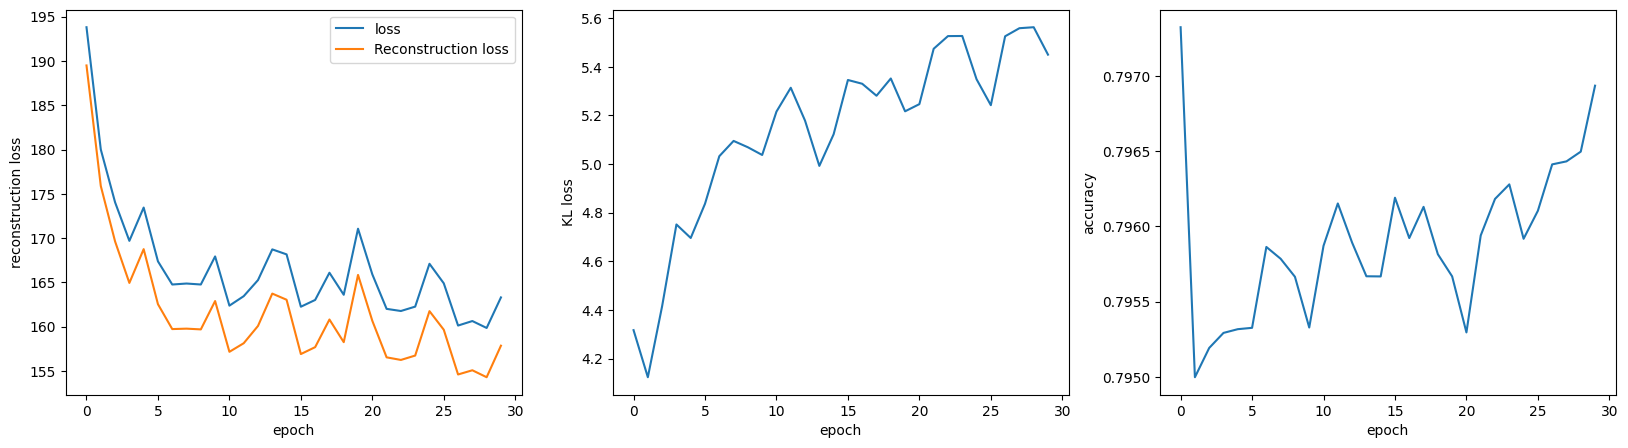

In [18]:
plot_metrics(historycvae2)

313/313 [==============================] - 0s 796us/step


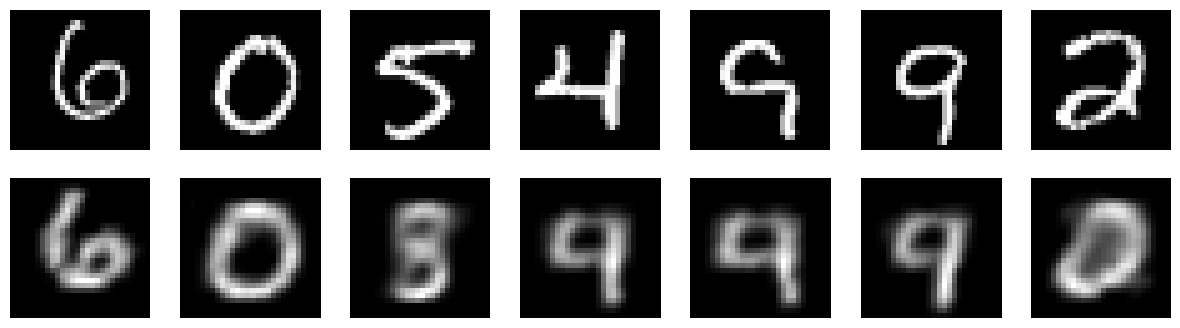

In [67]:
plot_test_preds(cvae2)

1875/1875 [==============================] - 1s 515us/step


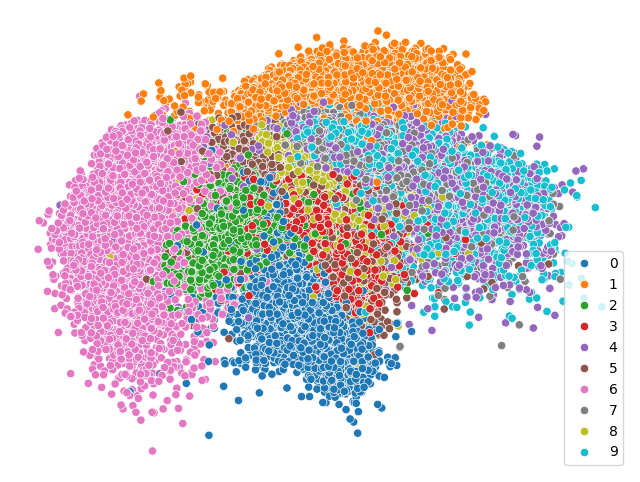

In [27]:
plot_latent_space(cencoder2)

1875/1875 [==============================] - 1s 455us/step


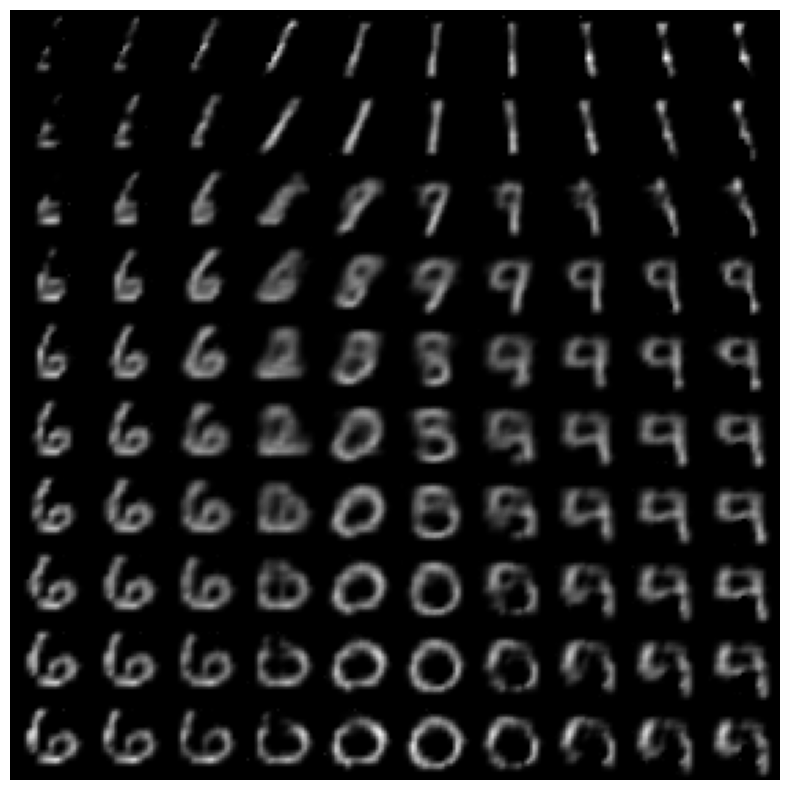

In [21]:
plot_latent_samples(cencoder2, cdecoder2)

Latent dimension of 5:

In [28]:
historycvae5, cvae5, cencoder5, cdecoder5 = train_conv_model(5)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 173.3527 - recon_loss_func: 165.0184 - accuracy: 0.7998 - kl_loss: 8.3340 - val_loss: 170.3307 - val_recon_loss_func: 162.0848 - val_accuracy: 0.7953 - val_kl_loss: 8.2473
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 156.1533 - recon_loss_func: 146.3982 - accuracy: 0.8001 - kl_loss: 9.7551 - val_loss: 155.3961 - val_recon_loss_func: 146.3199 - val_accuracy: 0.8040 - val_kl_loss: 9.0771
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 152.4003 - recon_loss_func: 142.4990 - accuracy: 0.8006 - kl_loss: 9.9012 - val_loss: 142.6050 - val_recon_loss_func: 132.6441 - val_accuracy: 0.8023 - val_kl_loss: 9.9619
Epoch 4/30
1875/1875 [==============================] - 5s 2ms/step - loss: 151.2632 - recon_loss_func: 141.4647 - accuracy: 0.8007 - kl_loss: 9.7985 - val_loss: 150.8968 - val_recon_loss_func: 141.2649 - val_accuracy: 0.7989 - val_kl_loss: 9.6327
Epoch 5/

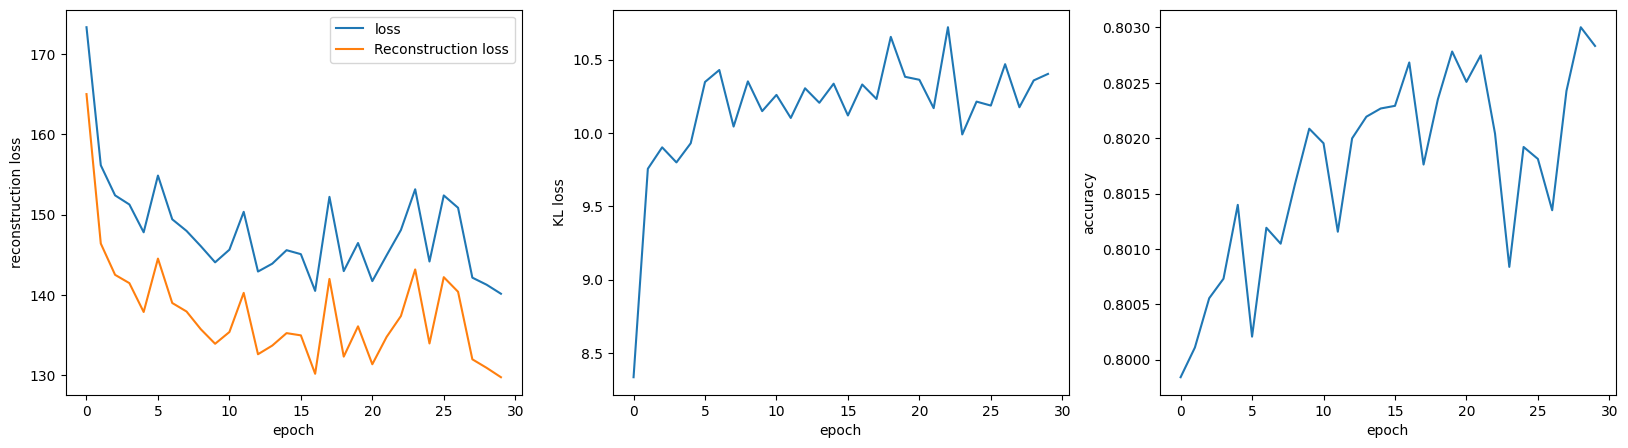

In [29]:
plot_metrics(historycvae5)

313/313 [==============================] - 0s 773us/step


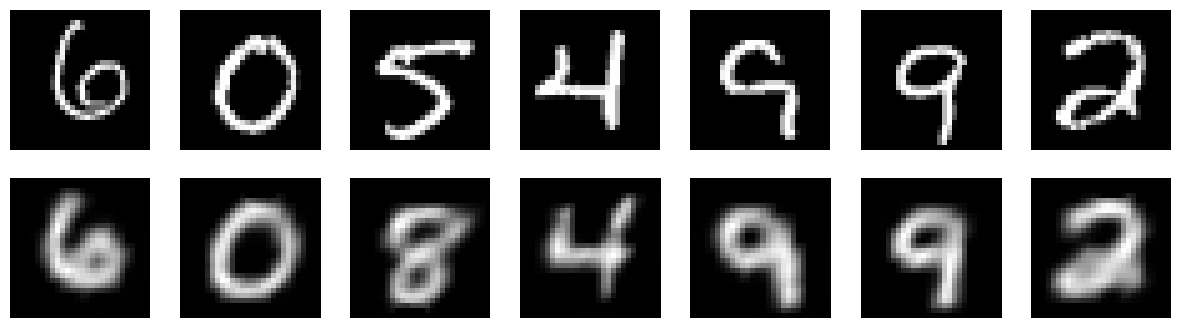

In [68]:
plot_test_preds(cvae5)

In [31]:
z_sample5 = cencoder5.predict(x_train)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(z_sample5)

1875/1875 [==============================] - 1s 447us/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.021s...
[t-SNE] Computed neighbors for 60000 samples in 1.950s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=y_train, palette="Set1", ax=ax);

Conclusion: using a convolutional neural network as the architecture does not improve the results much from before.

In this content, **for the variational autoencoder, the results depends much more on the latent space dimensions and loss function definitions, than the architecture of the model.** MNIST is simple enough that just a basic dense NN can describe the images well.

## Comparing different latent space dimensions

In [33]:
history2, vae2, encoder2, decoder2 = train_dense_model(2)

Epoch 1/30
1875/1875 [==============================] - 6s 2ms/step - loss: 165.8459 - recon_loss_func: 160.5875 - accuracy: 0.7947 - kl_loss: 5.2583 - val_loss: 155.9848 - val_recon_loss_func: 150.2743 - val_accuracy: 0.7948 - val_kl_loss: 5.7106
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 152.3863 - recon_loss_func: 146.4517 - accuracy: 0.7969 - kl_loss: 5.9347 - val_loss: 150.2731 - val_recon_loss_func: 144.3402 - val_accuracy: 0.7969 - val_kl_loss: 5.9331
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 148.5262 - recon_loss_func: 142.2746 - accuracy: 0.7977 - kl_loss: 6.2517 - val_loss: 147.4529 - val_recon_loss_func: 141.0650 - val_accuracy: 0.7979 - val_kl_loss: 6.3883
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 146.2612 - recon_loss_func: 139.8434 - accuracy: 0.7983 - kl_loss: 6.4179 - val_loss: 146.5351 - val_recon_loss_func: 139.8132 - val_accuracy: 0.7983 - val_kl_loss: 6.7221
Epoch 5/

In [34]:
history5, vae5, encoder5, decoder5 = train_dense_model(5)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 139.5198 - recon_loss_func: 129.2552 - accuracy: 0.8010 - kl_loss: 10.2647 - val_loss: 127.2137 - val_recon_loss_func: 116.3689 - val_accuracy: 0.8029 - val_kl_loss: 10.8455
Epoch 2/30
1875/1875 [==============================] - 5s 2ms/step - loss: 125.0423 - recon_loss_func: 113.7843 - accuracy: 0.8039 - kl_loss: 11.2581 - val_loss: 122.8023 - val_recon_loss_func: 111.4728 - val_accuracy: 0.8034 - val_kl_loss: 11.3294
Epoch 3/30
1875/1875 [==============================] - 5s 2ms/step - loss: 121.2892 - recon_loss_func: 109.6384 - accuracy: 0.8050 - kl_loss: 11.6507 - val_loss: 120.2745 - val_recon_loss_func: 108.6381 - val_accuracy: 0.8043 - val_kl_loss: 11.6358
Epoch 4/30
1875/1875 [==============================] - 5s 2ms/step - loss: 118.9223 - recon_loss_func: 107.0045 - accuracy: 0.8057 - kl_loss: 11.9179 - val_loss: 118.4914 - val_recon_loss_func: 106.6329 - val_accuracy: 0.8043 - val_kl_loss: 11.8585


In [35]:
history10, vae10, encoder10, decoder10 = train_dense_model(10)

Epoch 1/30
1875/1875 [==============================] - 6s 2ms/step - loss: 126.7202 - recon_loss_func: 110.9344 - accuracy: 0.8061 - kl_loss: 15.7858 - val_loss: 112.2089 - val_recon_loss_func: 94.6485 - val_accuracy: 0.8087 - val_kl_loss: 17.5618
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 110.8696 - recon_loss_func: 93.2364 - accuracy: 0.8097 - kl_loss: 17.6333 - val_loss: 108.4007 - val_recon_loss_func: 91.1181 - val_accuracy: 0.8095 - val_kl_loss: 17.2843
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 107.5099 - recon_loss_func: 89.4615 - accuracy: 0.8105 - kl_loss: 18.0483 - val_loss: 105.9128 - val_recon_loss_func: 87.8919 - val_accuracy: 0.8101 - val_kl_loss: 18.0217
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 105.5211 - recon_loss_func: 87.2367 - accuracy: 0.8110 - kl_loss: 18.2844 - val_loss: 104.8354 - val_recon_loss_func: 86.3747 - val_accuracy: 0.8100 - val_kl_loss: 18.4620
Epoch 5

313/313 [==============================] - 0s 673us/step


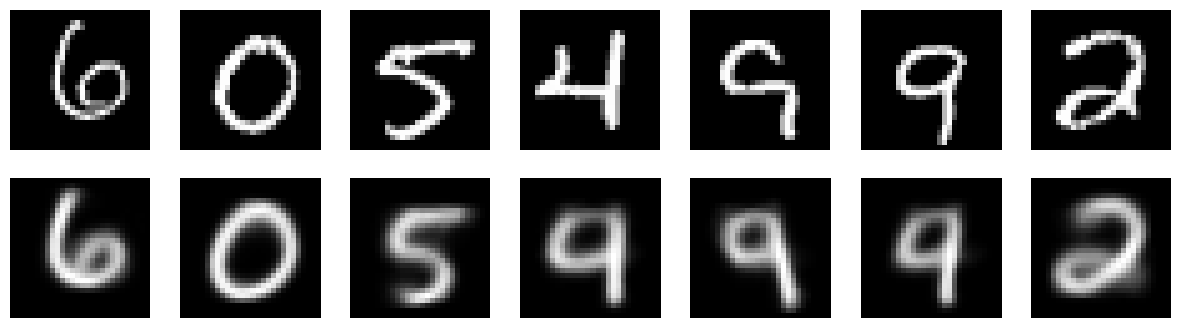

In [69]:
plot_test_preds(vae2);

In [70]:
plot_test_preds(vae5);

313/313 [==============================] - 0s 665us/step


313/313 [==============================] - 0s 670us/step


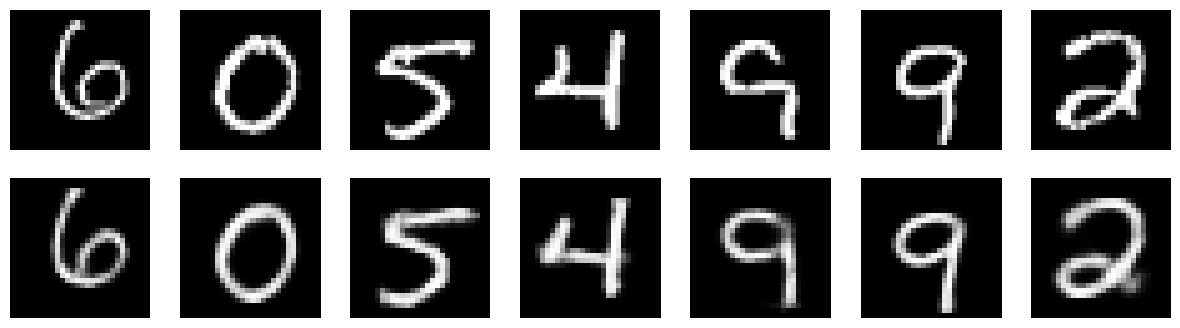

In [71]:
plot_test_preds(vae10);

The larger the latent space dimensions, the better the construction is - at 10 dimensions, we have an almost perfect construction, compared to the very fuzzy reconstructions from the 2 latent space features.

## Comparing different loss function set ups

For comparison, the normal set up with 2 latent space dimensions, and the normal loss function with both KL and reconstruction loss:

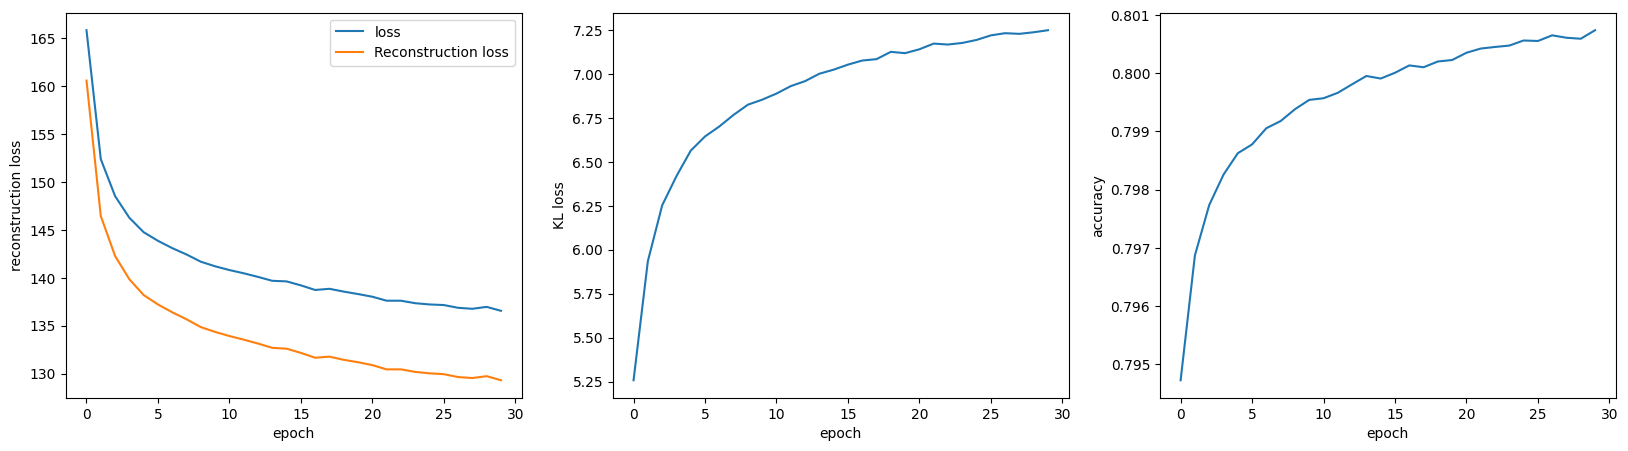

In [39]:
plot_metrics(history2)

Only training with construction loss (2 latent dimensions):

In [40]:
historyconst, vaeconst, encoderconst, decoderconst = train_dense_model(2, recon_loss=True, kl_loss=False, beta=0)

Epoch 1/30
1875/1875 [==============================] - 5s 2ms/step - loss: 157.3491 - recon_loss_func: 157.3491 - accuracy: 0.7951 - kl_loss: 0.0000e+00 - val_loss: 146.2061 - val_recon_loss_func: 146.2061 - val_accuracy: 0.7950 - val_kl_loss: 0.0000e+00
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 143.5073 - recon_loss_func: 143.5073 - accuracy: 0.7976 - kl_loss: 0.0000e+00 - val_loss: 142.2657 - val_recon_loss_func: 142.2657 - val_accuracy: 0.7983 - val_kl_loss: 0.0000e+00
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 139.8119 - recon_loss_func: 139.8119 - accuracy: 0.7984 - kl_loss: 0.0000e+00 - val_loss: 138.3073 - val_recon_loss_func: 138.3073 - val_accuracy: 0.7985 - val_kl_loss: 0.0000e+00
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 137.7159 - recon_loss_func: 137.7159 - accuracy: 0.7988 - kl_loss: 0.0000e+00 - val_loss: 136.9594 - val_recon_loss_func: 136.9594 - val_accuracy: 0.7983 - 

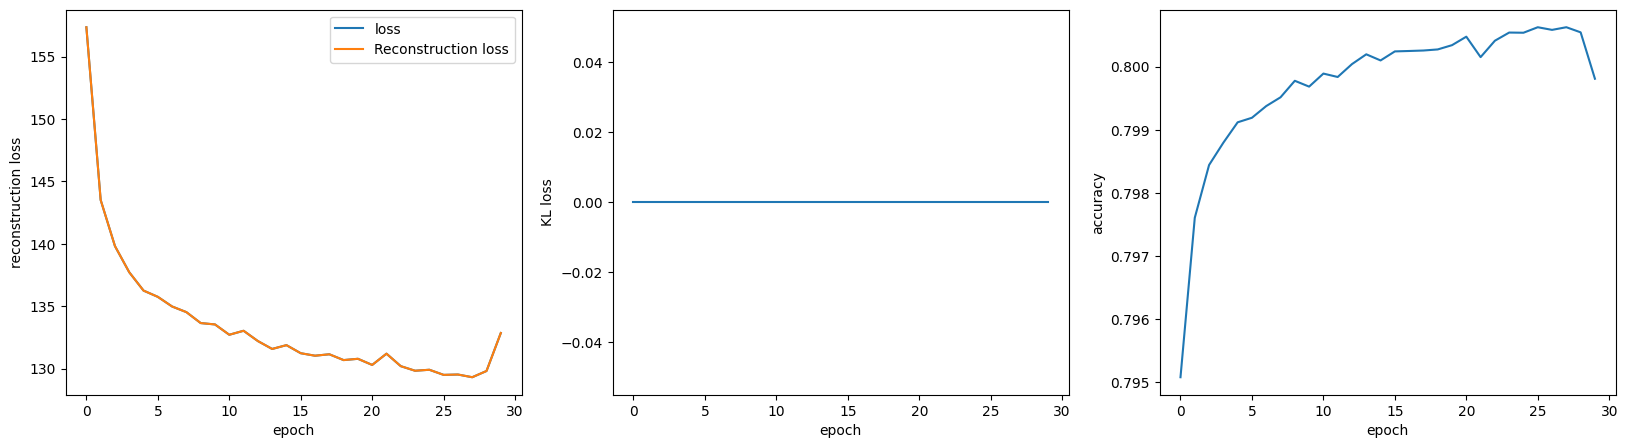

In [41]:
plot_metrics(historyconst)

Only training with KL-divergence loss (2 latent dimensions):

In [42]:
historykl, vaekl, encoderkl, decoderkl = train_dense_model(2, recon_loss=False, kl_loss=True, beta=0)

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - recon_loss_func: 543.7013 - accuracy: 0.4058 - kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss_func: 543.6996 - val_accuracy: 0.4053 - val_kl_loss: 0.0000e+00
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - recon_loss_func: 543.6992 - accuracy: 0.4058 - kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss_func: 543.7091 - val_accuracy: 0.4052 - val_kl_loss: 0.0000e+00
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - recon_loss_func: 543.7014 - accuracy: 0.4058 - kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss_func: 543.7063 - val_accuracy: 0.4051 - val_kl_loss: 0.0000e+00
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0000e+00 - recon_loss_func: 543.7000 - accuracy: 0.4058 - kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss_func: 543.7045 - val_acc

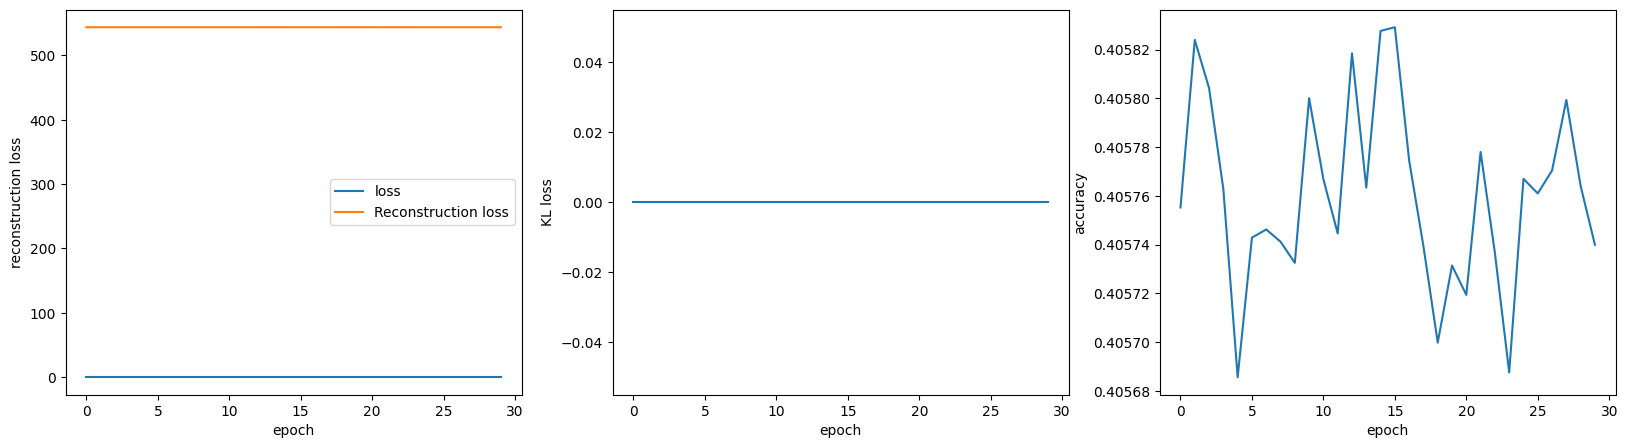

In [43]:
plot_metrics(historykl)

Weighting the KL-divergence loss (2 latent dimensions):

In [44]:
historyklhigh, vaeklhigh, encoderklhigh, decoderklhigh = train_dense_model(2, recon_loss=True, kl_loss=True, beta=15)

Epoch 1/30
1875/1875 [==============================] - 5s 2ms/step - loss: 204.6289 - recon_loss_func: 194.9186 - accuracy: 0.7965 - kl_loss: 9.7104 - val_loss: 200.3233 - val_recon_loss_func: 187.0987 - val_accuracy: 0.7966 - val_kl_loss: 13.2270
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 199.9176 - recon_loss_func: 182.6895 - accuracy: 0.7957 - kl_loss: 17.2280 - val_loss: 198.8674 - val_recon_loss_func: 179.5654 - val_accuracy: 0.7936 - val_kl_loss: 19.3029
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 198.9565 - recon_loss_func: 179.7097 - accuracy: 0.7954 - kl_loss: 19.2470 - val_loss: 198.5654 - val_recon_loss_func: 178.7864 - val_accuracy: 0.7939 - val_kl_loss: 19.7800
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 198.6183 - recon_loss_func: 178.3508 - accuracy: 0.7951 - kl_loss: 20.2679 - val_loss: 198.6608 - val_recon_loss_func: 177.8523 - val_accuracy: 0.7947 - val_kl_loss: 20.8094
E

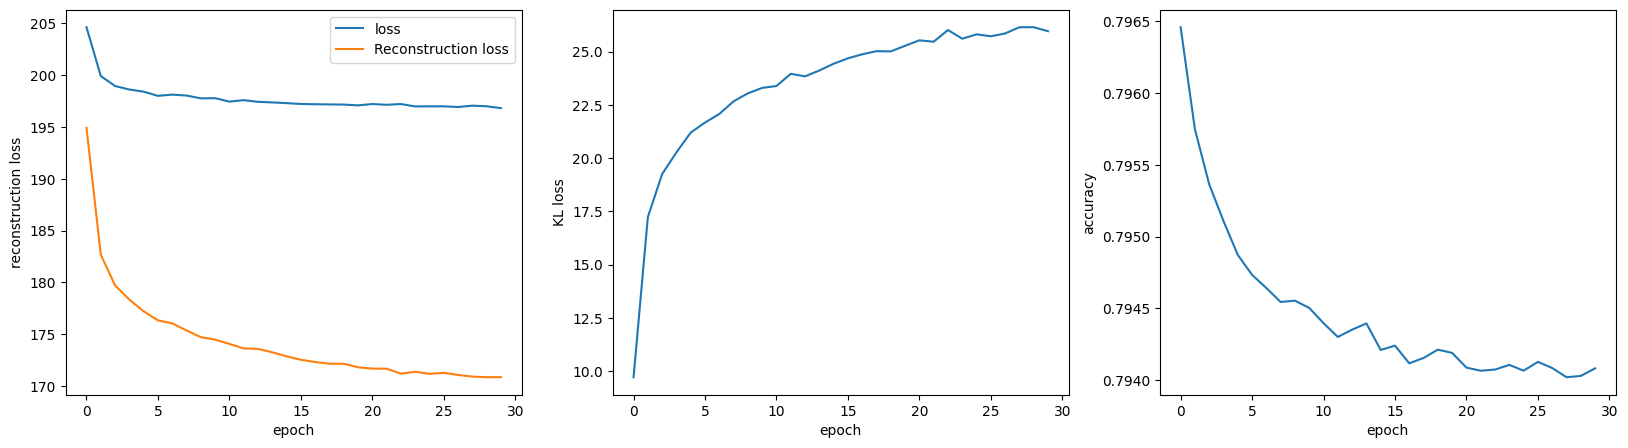

In [45]:
plot_metrics(historyklhigh)

In [46]:
historykllow, vaekllow, encoderkllow, decoderkllow = train_dense_model(2, recon_loss=True, kl_loss=True, beta=0.1)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 158.2314 - recon_loss_func: 156.9755 - accuracy: 0.7953 - kl_loss: 1.2558 - val_loss: 146.3295 - val_recon_loss_func: 145.1344 - val_accuracy: 0.7963 - val_kl_loss: 1.1951
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 143.7907 - recon_loss_func: 142.6266 - accuracy: 0.7977 - kl_loss: 1.1641 - val_loss: 141.8692 - val_recon_loss_func: 140.7295 - val_accuracy: 0.7980 - val_kl_loss: 1.1396
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 140.4966 - recon_loss_func: 139.3556 - accuracy: 0.7983 - kl_loss: 1.1408 - val_loss: 139.4695 - val_recon_loss_func: 138.3276 - val_accuracy: 0.7978 - val_kl_loss: 1.1418
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 137.9749 - recon_loss_func: 136.8482 - accuracy: 0.7988 - kl_loss: 1.1267 - val_loss: 137.6649 - val_recon_loss_func: 136.5790 - val_accuracy: 0.7985 - val_kl_loss: 1.0856
Epoch 5/

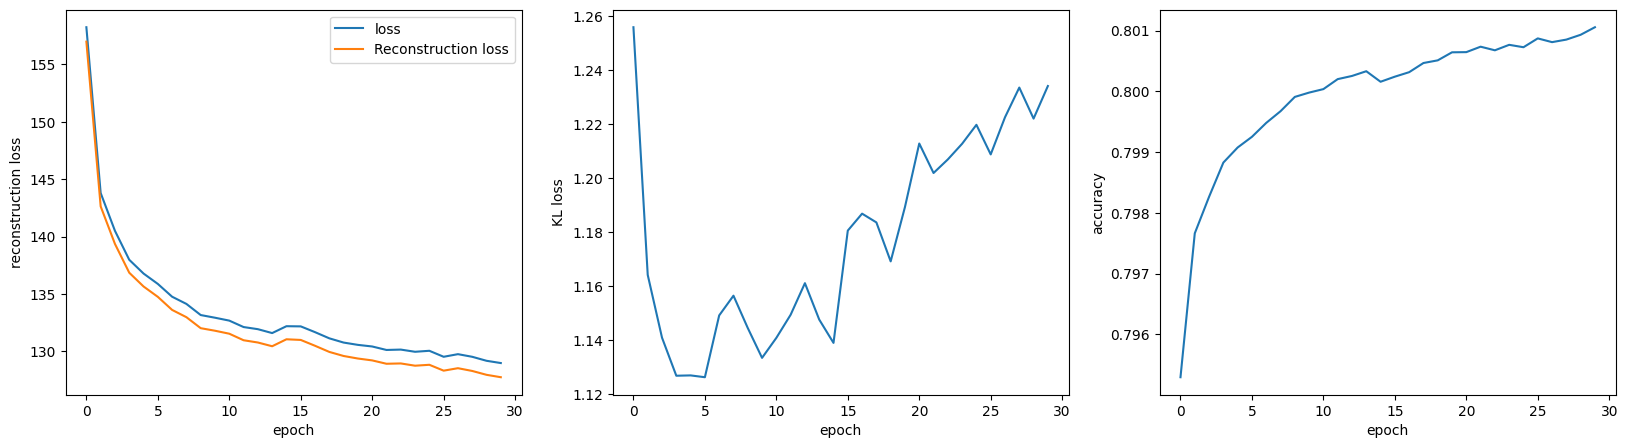

In [47]:
plot_metrics(historykllow)

In [48]:
z_bothloss = encoder2.predict(x_train)
z_closs = encoderconst.predict(x_train)
z_klloss = encoderkl.predict(x_train)
z_highklloss = encoderklhigh.predict(x_train)
z_lowklloss = encoderkllow.predict(x_train)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 3))
sns.scatterplot(x=z_bothloss[:, 1], y=z_bothloss[:, 0], hue=y_train, palette="tab10", s=5, ax=axes[0]).set(title="Construction & KL Loss");
sns.scatterplot(x=z_closs[:, 1], y=z_closs[:, 0], hue=y_train, palette="tab10", s=5, ax=axes[1]).set(title="Construction Loss");
sns.scatterplot(x=z_klloss[:, 1], y=z_klloss[:, 0], hue=y_train, palette="tab10", s=5, ax=axes[2]).set(title="KL Loss");
sns.scatterplot(x=z_highklloss[:, 1], y=z_highklloss[:, 0], hue=y_train, palette="tab10", s=5, ax=axes[3]).set(title="Construction & High KL Loss");
sns.scatterplot(x=z_lowklloss[:, 1], y=z_lowklloss[:, 0], hue=y_train, palette="tab10", s=5, ax=axes[4]).set(title="Construction & Low KL Loss");
for ax in axes:
  ax.invert_yaxis();

1875/1875 [==============================] - 1s 406us/step


With construction loss only, the different numbers are well separated in the latent space, but there is a lot of gaps between them - hence a lot of "meaningless" space that could be sampled from. Even with a VAE utilising distributions, the latent space lacks completeness without the additional KL-divergence loss term.

With KL loss only, the distribution perfectly reflects a standard normal distribution, and nothing else. The construction loss is not even optimised for.

When KL is weighted more highly (greater than 1), versus more lowly (less than 1), the distribution appears to be more normal, and is hence more complete, with far fewer gaps, hence is a better latent space to sample from.

1875/1875 [==============================] - 1s 444us/step


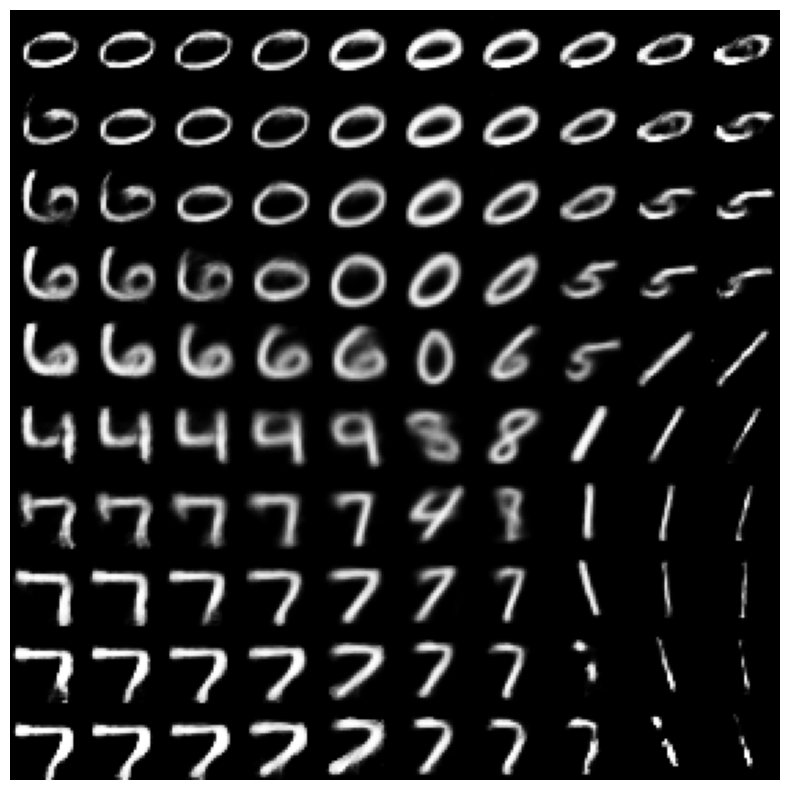

In [49]:
plot_latent_samples(encoder2, decoder2)

The "default" VAE has some structure, but the gaps have resulted in meaningless reconstructions, particularly in the bottom right.

1875/1875 [==============================] - 1s 412us/step


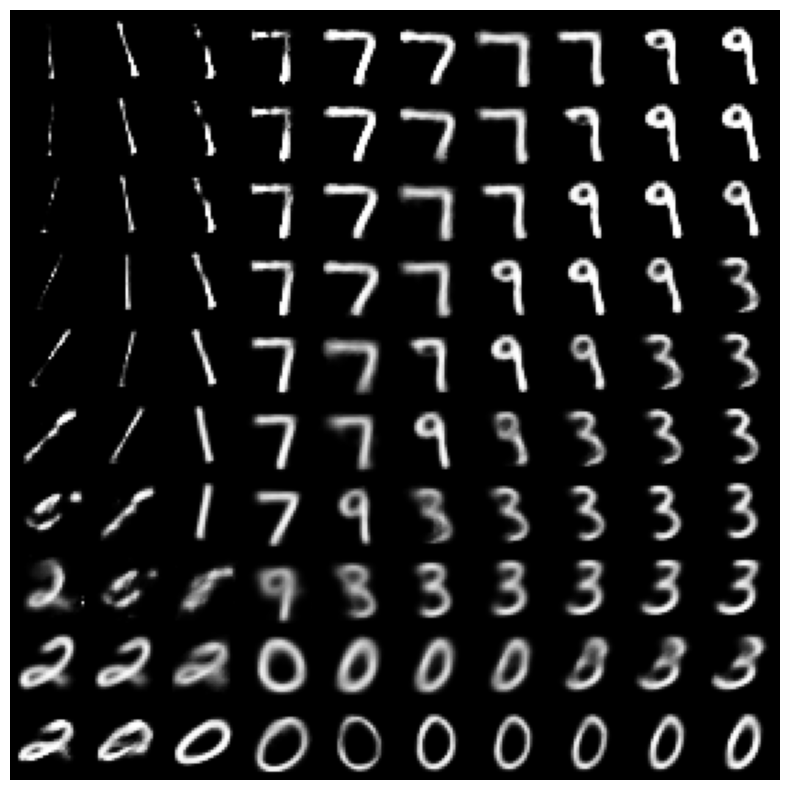

In [50]:
plot_latent_samples(encoderconst, decoderconst)

The structure of the latent space when optimising for construction loss only, is quite strange.

1875/1875 [==============================] - 1s 409us/step


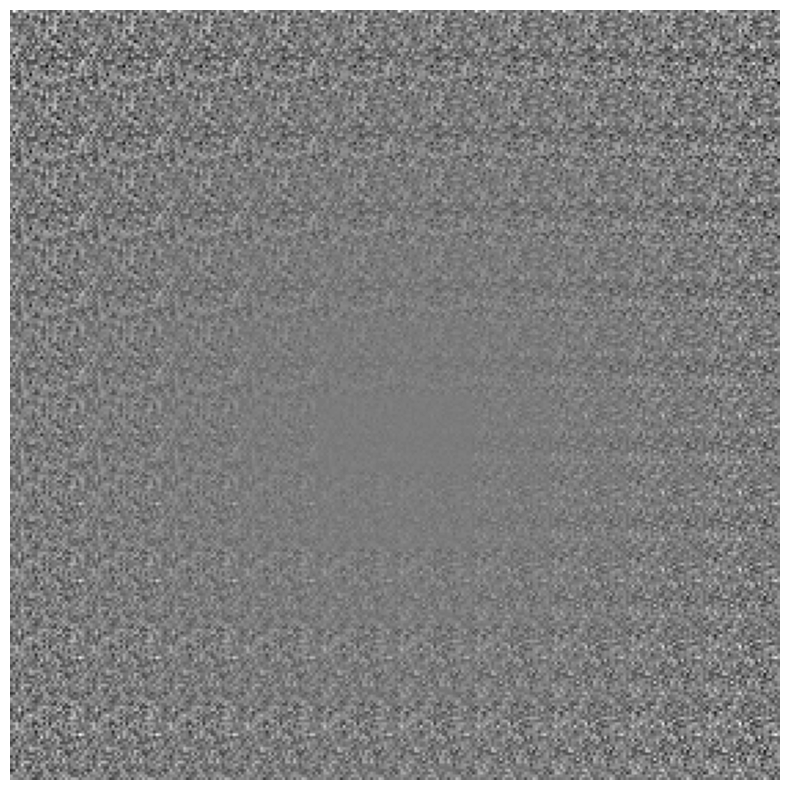

In [51]:
plot_latent_samples(encoderkl, decoderkl)

The structure of the latent space when optimising for KL loss only, is meaningless.

1875/1875 [==============================] - 1s 432us/step


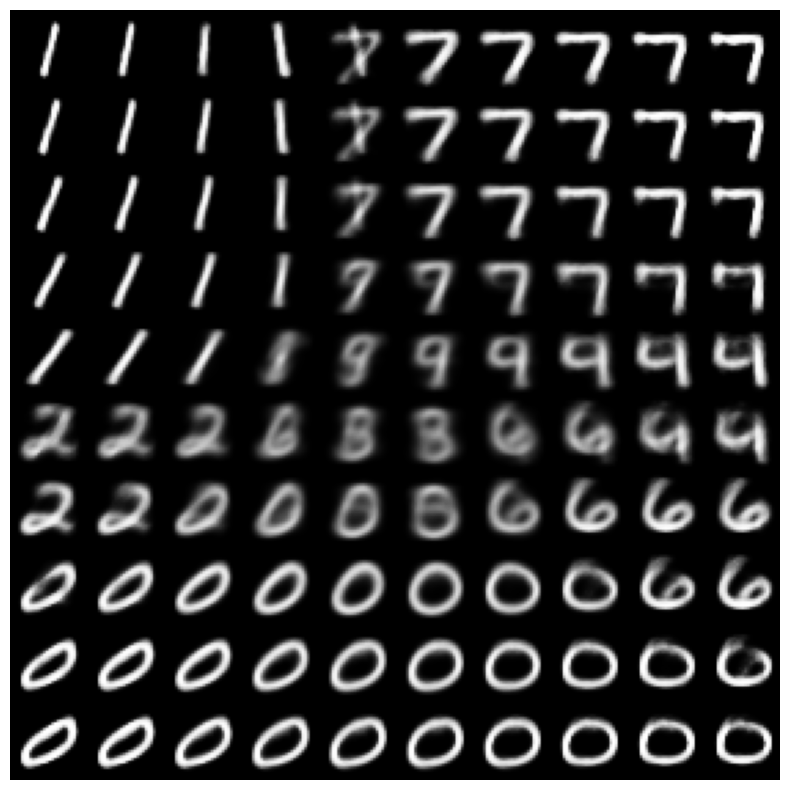

In [52]:
plot_latent_samples(encoderklhigh, decoderklhigh)

The structure of the latent space when optimising for both the reconstruction and KL loss weighted more highly, is very strongly structured and clearly separated.

1875/1875 [==============================] - 1s 411us/step


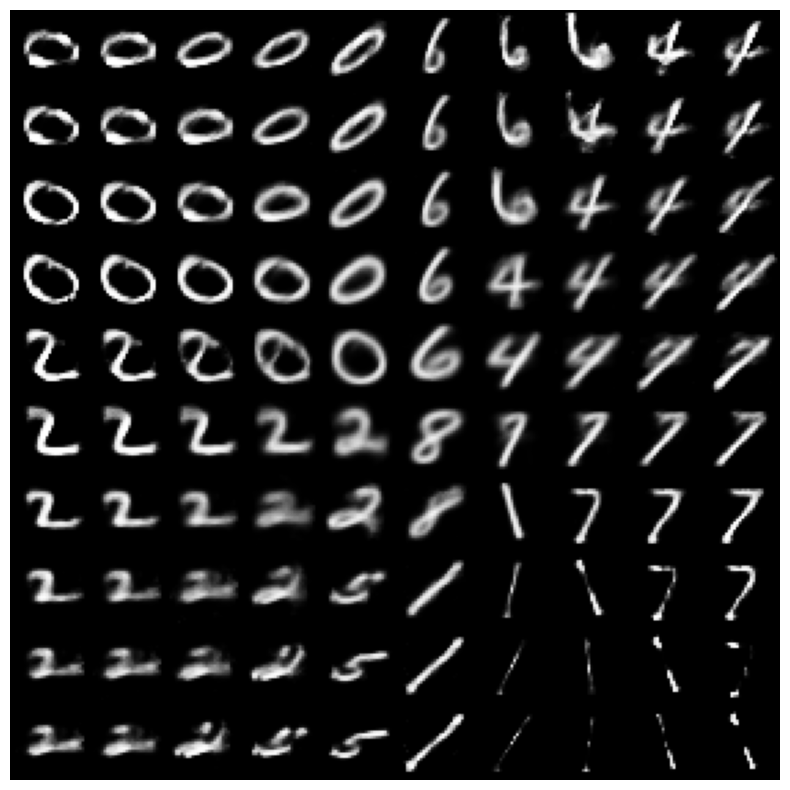

In [53]:
plot_latent_samples(encoderkllow, decoderkllow)

When the KL-divergence loss term is low, much of the latent space becomes meaningless again, with strange looking reconstructions of numbers.